# Informe de Cosechas - Superfinanciera Colombia (SFC) - Contexto
El Informe de Cosechas, es un reporte regulatorio exigido a las entidades financieras supervisadas por la SFC (bancos, corporaciones financieras, entre otras).

Mensualmente las entidades deben reportar la cantidad de créditos desembolsados y el valor en pesos colombianos de dichos desembolsos por línea de credito ofrecida de la cartera de créditos de consumo, vivienda microcrédito.

Uds. fueron contratados por una entidad financiera para realizar un modelo predictivo que permita estimar los desembolsos mensuales en el sistema financiero.

El dataset de este reporte se encuentra almacenado en "datos.gov.co", específicamente en el vínculo "https://www.datos.gov.co/resource/7jfv-7spn.csv".  Cada registro representa el acumulado mensual por entidad de los desembolsos por línea de crédito.

Puede encontrar la información del dataset en "https://www.datos.gov.co/Hacienda-y-Cr-dito-P-blico/Montos-y-n-mero-de-cr-ditos-aprobados-o-desembolsa/7jfv-7spn/about_data


## Objetivos (pregunta SMART)
**En esta 1ra.** etapa del análisis, se busca realizar un análisis exploratorio de la información, a través del siguiente interrogante:

**Pregunta No.1:  ¿Cuál es el comportamiento de la tasa de intervención y de los montos y nro. de créditos de consumo, vivienda y microcrédito, desembolsados en el sistema financiero desde enero de 2011 hasta octubre de 2023?**
 
Nota: el objetivo del **análisis en una 2da. etapa** consistirá en **predecir** la colocación de créditos de consumo, vivienda y microcrédito en el sistema financiero Colombiano a partir los cambios en la política monetaria Banrep (tasa de intervención) para el 2024


**Pregunta No.2: ¿Cuáles serán los montos desembolsados de créditos de consumo, vivienda y microcrédito en el sistema financiero para el 2024, conforme a la tasa de intervención del Banco de la República?**

## Descripción de los campos  (diccionario)

TIPO_ENTIDAD:
Tipo de entidad del sistema financiero colombiano (Número, variable categórica, cualitativa nominal)

NOMBRE_TIPO_ENTIDAD:	
Descripción del código de tipo de entidad (texto, variable categórica, cualitativa nominal)

CODIGO_ENTIDAD:	
ID de la entidad ante el sistema finanicero (Número, variable categórica, cualitativa nominal)

NOMBRE_ENTIDAD:	
Nombre de la entidad (texto, variable categórica, cualitativa nominal)

FECHA_CORTE:	
Fecha de la transmisión de la información (fecha y hora, Fecha)

CODIGO_RENGLON:	
Código de la línea del crédito (Número, variable categórica, cualitativa nominal)

NOMBRE_RENGLON:	
Nombre de la línea del crédito (texto, variable categórica, cualitativa nominal)

MONTOS_APROBADOS:	
Valor total de los montos aprobados por línea de crédito y entidad en el mes (Número, variable cuantitativa continua)

NUMERO_CREDITOS:	
Cantidad de créditos aprobados por línea de crédito y entidad en el mes (Número, variable cuantitativa discreta)


## Obtener los datos

In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format #corregir opciones de formato numérico de la interfaz
pd.set_option('display.max_rows', None) # mostrar todas las filas al visualizar dataframes
pd.set_option('display.max_columns', None) #mostrar todas las columnas al visualizar dataframes
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt  ## Libreria para visualizar
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

#Estadísticas
from scipy.stats import skew, kurtosis  ## funciones estadísticas
from scipy.stats import norm ## distribución normal
from sklearn.pipeline import Pipeline #librería machine learning (entrenamiento de modelos)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split #dividir los datos entre entrenamientos y testeo
from sklearn.preprocessing import StandardScaler


#cargue de funciones:
# Funcion para estadísticas descriptivas variables cuantitativas
def tabla_descriptivas(columnas):
    tabla_descriptivas=pd.DataFrame(columnas.describe())
    tabla_descriptivas.loc['coef. variation 0.30 | 0.30-0.70 | 0.70']=columnas.std()/columnas.mean()
    tabla_descriptivas.loc['skew < 0 sesgo izquierda | > 0 sesgo derecha ']=skew(columnas) #Sesgo o asimetría
    tabla_descriptivas.loc['kurtosis <0 achatada platicurtica | > 0 empinada leptocurtica']=kurtosis(columnas)
    q1=columnas.quantile(0.25)
    q3=columnas.quantile(0.75)
    IQR=q3-q1
    outliers = columnas[ ((columnas<(q1-1.5*IQR)) | (columnas>(q3+1.5*IQR))) ]
    outlier_minimos = columnas[columnas<(q1-1.5*IQR)]
    outlier_maximos = columnas[columnas>(q3+1.5*IQR)]    
    tabla_descriptivas.loc['Umbral atípicos minimo']=  columnas.quantile(0.25) - (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5 
    tabla_descriptivas.loc['Umbral atípicos maximo']=  columnas.quantile(0.75) + (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5 
    tabla_descriptivas.loc['cantidad atipicos minimos']=   len(outlier_minimos)
    tabla_descriptivas.loc['cantidad atipicos maximos']= len(outlier_maximos)
    tabla_descriptivas.loc['cantidad_total_atípicos']= len(outliers)
    
    
    return tabla_descriptivas

In [2]:
df = pd.read_csv("20240305_01_Cosechas_20240305.csv")

In [3]:
df.shape

(44873, 9)

In [4]:
df.head() #validar cargue de los datos

,TIPO_ENTIDAD,NOMBRE_TIPO_ENTIDAD,CODIGO_ENTIDAD,NOMBRE_ENTIDAD,FECHA_CORTE,CODIGO_RENGLON,NOMBRE_RENGLON,MONTOS_APROBADOS,NUMERO_CREDITOS
0,1,BC-ESTABLECIMIENTO BANCARIO,51,"""Bancien S.A."" Y/O ""Ban100""",31/01/2011,40,Microcreditos < o Iguales a 25 SMMLV,"756,718,249.0000",148
1,1,BC-ESTABLECIMIENTO BANCARIO,51,"""Bancien S.A."" Y/O ""Ban100""",31/01/2011,45,Microcreditos > a 25 y hasta 120 SMMLV,"546,396,838.0000",24
2,1,BC-ESTABLECIMIENTO BANCARIO,42,"""Banco Colpatria"", ""Scotiabank""",31/01/2011,5,Credito Rotativo,"4,340,870,000.0000",367
3,1,BC-ESTABLECIMIENTO BANCARIO,42,"""Banco Colpatria"", ""Scotiabank""",31/01/2011,25,Libranza,"9,057,702,000.0000",661
4,1,BC-ESTABLECIMIENTO BANCARIO,42,"""Banco Colpatria"", ""Scotiabank""",31/01/2011,20,Libre Inversion,"15,783,916,475.0000",1220


In [5]:
#validar calidad de la completitud de datos del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44873 entries, 0 to 44872
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TIPO_ENTIDAD         44873 non-null  int64  
 1   NOMBRE_TIPO_ENTIDAD  44873 non-null  object 
 2   CODIGO_ENTIDAD       44873 non-null  int64  
 3   NOMBRE_ENTIDAD       44873 non-null  object 
 4   FECHA_CORTE          44873 non-null  object 
 5   CODIGO_RENGLON       44873 non-null  int64  
 6   NOMBRE_RENGLON       44873 non-null  object 
 7   MONTOS_APROBADOS     44873 non-null  float64
 8   NUMERO_CREDITOS      44873 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 3.1+ MB


Se observa un dataset con 44873 registros.

**Observación:  al ser un reporte la regulatorio, los controles de cargue a la superfinaciera son bastante extrictos. Dentro de este tipo de controles, los datos no pueden venir vacíos.**

La fecha de corte presenta inconsistencias de formato, se debe corregir de object a fecha.

A los registros del nombre de la entidad debemos eliminarles las comillas por términos de limpieza

In [6]:
df['FECHA_CORTE'] = pd.to_datetime(df['FECHA_CORTE'], format='%d/%m/%Y')
df.head() 

,TIPO_ENTIDAD,NOMBRE_TIPO_ENTIDAD,CODIGO_ENTIDAD,NOMBRE_ENTIDAD,FECHA_CORTE,CODIGO_RENGLON,NOMBRE_RENGLON,MONTOS_APROBADOS,NUMERO_CREDITOS
0,1,BC-ESTABLECIMIENTO BANCARIO,51,"""Bancien S.A."" Y/O ""Ban100""",2011-01-31,40,Microcreditos < o Iguales a 25 SMMLV,"756,718,249.0000",148
1,1,BC-ESTABLECIMIENTO BANCARIO,51,"""Bancien S.A."" Y/O ""Ban100""",2011-01-31,45,Microcreditos > a 25 y hasta 120 SMMLV,"546,396,838.0000",24
2,1,BC-ESTABLECIMIENTO BANCARIO,42,"""Banco Colpatria"", ""Scotiabank""",2011-01-31,5,Credito Rotativo,"4,340,870,000.0000",367
3,1,BC-ESTABLECIMIENTO BANCARIO,42,"""Banco Colpatria"", ""Scotiabank""",2011-01-31,25,Libranza,"9,057,702,000.0000",661
4,1,BC-ESTABLECIMIENTO BANCARIO,42,"""Banco Colpatria"", ""Scotiabank""",2011-01-31,20,Libre Inversion,"15,783,916,475.0000",1220


In [7]:
df["FECHA_CORTE"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 44873 entries, 0 to 44872
Series name: FECHA_CORTE
Non-Null Count  Dtype         
--------------  -----         
44873 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 350.7 KB


Verificamos que la información de las fechas ha sido formateada correctamente

In [8]:
df["NOMBRE_ENTIDAD"] = df["NOMBRE_ENTIDAD"].str.replace('"','' )

Eliminamos las comillas en la columna "NOMBRE_ENTIDAD"

In [9]:
df.duplicated().sum()

0

El data set no presenta registrador duplicados

In [10]:
columnas_a_eliminar = ["TIPO_ENTIDAD", "CODIGO_ENTIDAD", "CODIGO_RENGLON"]
df = df.drop(columns=columnas_a_eliminar)

Eliminamos columnas para evitar colinealidad

In [11]:
df = df.rename(columns={"NOMBRE_RENGLON": "LINEA_CREDITO"})
df.head(1)

,NOMBRE_TIPO_ENTIDAD,NOMBRE_ENTIDAD,FECHA_CORTE,LINEA_CREDITO,MONTOS_APROBADOS,NUMERO_CREDITOS
0,BC-ESTABLECIMIENTO BANCARIO,Bancien S.A. Y/O Ban100,2011-01-31,Microcreditos < o Iguales a 25 SMMLV,"756,718,249.0000",148


Renombramos algunas columnas por textos más persuasivos

## Análisis de variables

### Análisis de variables categóricas

In [12]:
display(pd.DataFrame(df["NOMBRE_TIPO_ENTIDAD"].unique()))

,0
0,BC-ESTABLECIMIENTO BANCARIO
1,CF-COMPAÑÍA DE FINANCIAMIENTO
2,COOPERATIVAS DE CARÁCTER FINANCIERO
3,OCGS-ORGANISMO COOPERATIVO DE GRADO SUPERIOR
4,INSTITUCIÓN OFICIAL ESPECIAL


Dentro de los tipos de entidades financieras encontramos 5 opciones: no existen tipos de entidades desconocidas

In [13]:
entidades = pd.DataFrame(df["NOMBRE_ENTIDAD"].unique())
entidades.columns = ["ENTIDADES"]
entidades

,ENTIDADES
0,Bancien S.A. Y/O Ban100
1,"Banco Colpatria, Scotiabank"
2,Banco Serfinanza S.A.
3,Tuya
4,Av Villas
5,Banco Pichincha S.A.
6,Banagrario
7,Banco De Bogotá S.A.
8,Bancamía S.A.
9,Banco Caja Social


Se evidencian 63 entidades financieras reportadas

In [14]:
print("La fecha mínima del data set es: ", df["FECHA_CORTE"].min())
print("La fecha máxima del data set es: ", df["FECHA_CORTE"].max())
#df["FECHA_CORTE"].sort_values().unique()
fechas = pd.DataFrame(df["FECHA_CORTE"].sort_values().unique())
print("La cantidad de fechas distintas reportadas es:  ", fechas.count())

La fecha mínima del data set es:  2011-01-31 00:00:00
La fecha máxima del data set es:  2023-10-31 00:00:00
La cantidad de fechas distintas reportadas es:   0    154
dtype: int64


El data set contiene registros desde enero el mes de enero de 2011 hasta octubre de 2023, equivalente a 154 cortes

In [15]:
display(pd.DataFrame(df["LINEA_CREDITO"].sort_values().unique())) #identificamos y verificamos los tipos de crédito: cartera de consumo y microcrédito


,0
0,Compra Cartera Vivienda en Pesos
1,Compra Cartera Vivienda en UVR
2,Compra Credito Rotativo
3,Compra Libranza Consumo
4,Compra Libranza Vivienda VIS
5,Compra Libranza no Vivienda VIS
6,Compra Libre Inversion
7,Compra Tarjetas de Credito
8,Compra Vehiculo
9,Compra de Cartera de Consumo


Se evidencian múltiples tipos de crédito colocados, abarcando consumo, (vehículos, libre inversión, libranza, tarjeta de crédito, créditos rotativos), vivienda (vis y no vis) y microcréditos

## Análisis de variables cuantitativas

### Análisis de variables cuantitativas discretas (enteras)

#### Número de creditos

In [16]:
tabla_descriptivas(df["NUMERO_CREDITOS"])

,NUMERO_CREDITOS
count,"44,873.0000"
mean,"2,499.7278"
std,"7,253.5021"
min,0.0000
25%,18.0000
50%,185.0000
75%,"1,367.0000"
max,"470,249.0000"
coef. variation 0.30 | 0.30-0.70 | 0.70,2.9017
skew < 0 sesgo izquierda | > 0 sesgo derecha,11.5726


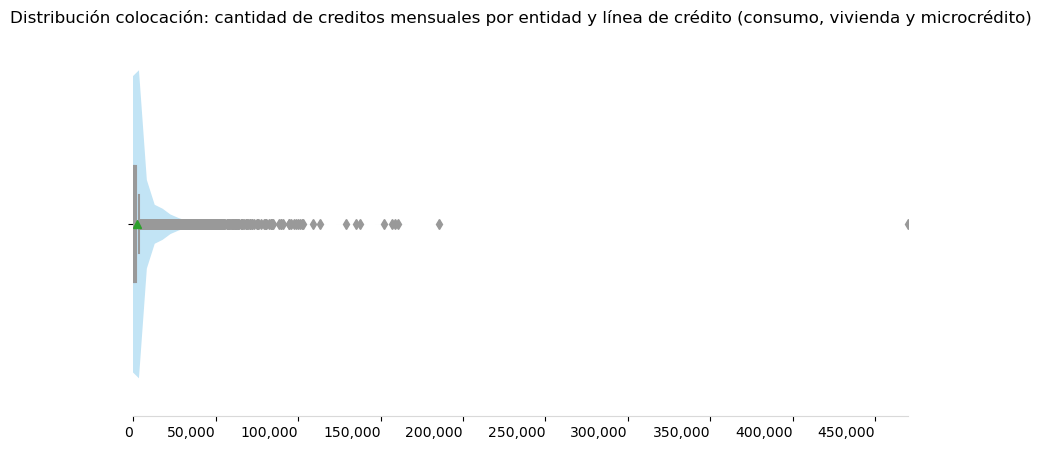

In [17]:
 #Matplotlib :figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE)), Tamaño gráfico
plt.figure(figsize=(10,5)) 


#Configura violín
ax = sns.violinplot(x=df['NUMERO_CREDITOS'],color="#B9E7FE",linewidth=0) 
#Configura boxplot
boxplot=sns.boxplot(x=df['NUMERO_CREDITOS'],color="White", showmeans=True, width=0.3, boxprops={'zorder':2}, ax=ax) # seaborn crea el boxplot, showmeans = mostrar media
boxplot.set_xlabel('') # cambia el título del eje x
boxplot.set_xlim(0, 470249) # cambia los límites del eje x
boxplot.set_xticks(range(0,470249,50000)) # cambia los valores del eje x
boxplot.set_title('Distribución colocación: cantidad de creditos mensuales por entidad y línea de crédito (consumo, vivienda y microcrédito)')
boxplot.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right') #rotar las etiquetas del eje x
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x * 1)) # función para el formato de datos del gráfico
boxplot.xaxis.set_major_formatter(formatter) #aplicar función para el formato de datos del gráfico


#Configura opciones de formato del gráfico
boxplot.spines["top"].set_visible(False)
boxplot.spines["right"].set_visible(False)
boxplot.spines["left"].set_visible(False)
plt.rcParams['font.family'] = 'Century Gothic'
plt.gca().spines['bottom'].set_color('#D9D9D9')
#plt.xlabel('FECHA_CORTE', color='#D9D9D9') cambia el color del título del eje x
#plt.tick_params(axis='x', colors='#D9D9D9') cambiar el color de las etiquetas del eje x


plt.show()

Conforme a la naturaleza de las entidades finacieras y las líneas de créditos, el número de créditos mensuales colocados puede presentar una gran variabilidad al momento de determinar un centro.

El centro de la distribución está en 185 créditos mensuales por línea y entidad, con el 50% de los datos agrupados alrededor de este centro entre 18 y 1367 créditos. La dispersión de los datoses muy alta (de acuerdo a la escala propuesta por Vargas-2007). La distribución contiene un gran sesgo a la derecha y empinamiento (alta concentración respecto a la media).

**Se sugiere agrupar los datos para hacer comparaciones más afines**

### Análisis de variables cuantitativas continuas

#### Montos aprobados

In [18]:
tabla_descriptivas(df["MONTOS_APROBADOS"])

,MONTOS_APROBADOS
count,"44,873.0000"
mean,"28,777,613,478.4839"
std,"77,394,882,719.3674"
min,0.0000
25%,"432,916,055.0000"
50%,"3,648,111,621.0000"
75%,"22,173,660,000.0000"
max,"1,747,254,160,126.0000"
coef. variation 0.30 | 0.30-0.70 | 0.70,2.6894
skew < 0 sesgo izquierda | > 0 sesgo derecha,7.7032


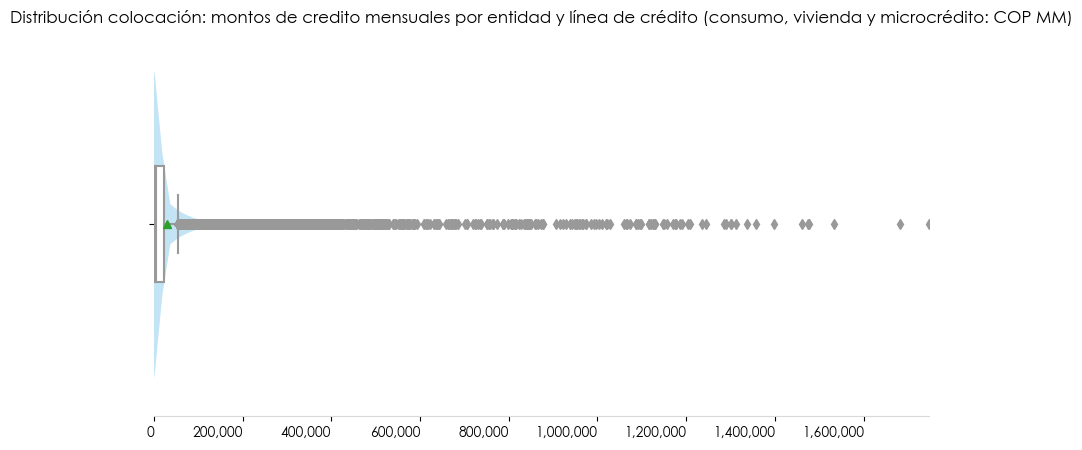

In [19]:
 #Matplotlib :figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE)), Tamaño gráfico
plt.figure(figsize=(10,5))

#Configura violín
ax = sns.violinplot(x=df['MONTOS_APROBADOS'],color="#B9E7FE",linewidth=0) 
#Configura boxplot
boxplot=sns.boxplot(x=df['MONTOS_APROBADOS'],color="White", showmeans=True, width=0.3, boxprops={'zorder':2}, ax=ax) # seaborn crea el boxplot, showmeans = mostrar media
boxplot.set_xlabel('') # cambia el título del eje x
boxplot.set_xlim(0, 1747254160126) # cambia los límites del eje x
boxplot.set_xticks(range(0, 1747254160126, 200000000000)) # cambia los valores del eje x
formatter_millions = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x * 1e-6)) # función para el formato de datos del gráfico
boxplot.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right') #rotar las etiquetas del eje x
boxplot.xaxis.set_major_formatter(formatter_millions) #aplicar función para el formato de datos del gráfico
boxplot.set_title('Distribución colocación: montos de credito mensuales por entidad y línea de crédito (consumo, vivienda y microcrédito: COP MM)')


#Configura opciones de formato del gráfico
boxplot.spines["top"].set_visible(False)
boxplot.spines["right"].set_visible(False)
boxplot.spines["left"].set_visible(False)
plt.rcParams['font.family'] = 'Century Gothic'
plt.gca().spines['bottom'].set_color('#D9D9D9')
#plt.xlabel('FECHA_CORTE', color='#D9D9D9') cambia el color del título del eje x
#plt.tick_params(axis='x', colors='#D9D9D9') cambiar el color de las etiquetas del eje x

plt.show()

Conforme a la naturaleza de las entidades finacieras y las líneas de créditos, el valor de desembolsos mensuales colocados puede presentar una gran variabilidad al momento de determinar un centro.

El centro de la distribución está en COP 3,648,111,621 mensuales por línea y entidad, con el 50% de los datos agrupados alrededor de este centro entre COP 432,916,055 y COP 22,173,660,000. La dispersión de los datos es alta (de acuerdo a la escala propuesta por Vargas-2007). La distribución contiene un gran sesgo a la derecha y empinamiento (alta concentración respecto a la media).

**RECOMENDACIÓN: se sugiere agrupar los datos para hacer comparaciones más afines**

## Agrupamiento de la información (mensual total sistema)


In [20]:
df_resumido = df.groupby("FECHA_CORTE").sum().reset_index()
df_resumido["year"] = [x.year for x in df_resumido.FECHA_CORTE]
df_resumido["mes"] = [x.month for x in df_resumido.FECHA_CORTE]
df_resumido["dia"] = [x.day for x in df_resumido.FECHA_CORTE]
df_resumido.head(3)


C:\Users\ACER\AppData\Local\Temp\ipykernel_20924\817461073.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resumido = df.groupby("FECHA_CORTE").sum().reset_index()


,FECHA_CORTE,MONTOS_APROBADOS,NUMERO_CREDITOS,year,mes,dia
0,2011-01-31,"2,981,208,267,185.6870",378499,2011,1,31
1,2011-02-28,"3,715,992,235,799.5889",448833,2011,2,28
2,2011-03-31,"4,422,082,621,005.3701",509119,2011,3,31


Se agrupa la información por mes y se crean las columnas "year"(año), "mes" y "dia" y se procede a realizar nuevamente un análisis de las variables continuas

### Análisis de variables

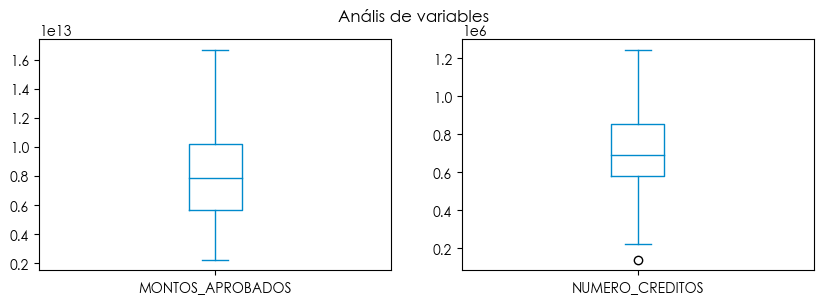

In [21]:
boxplot = df_resumido.drop(['FECHA_CORTE', "year", "mes", "dia"], axis=1).plot(kind='box', subplots=True, layout=(1,2), sharex=False, sharey=False, figsize=(10,3), title='Anális de variables', color="#008ACC" )
#Configura opciones de formato del gráfico
plt.rcParams['font.family'] = 'Century Gothic'
plt.show()

Se presentan datos atípicos en el número de créditos.

#### Numero de creditos (total sistema)

In [22]:
tabla_descriptivas(df_resumido["NUMERO_CREDITOS"])

,NUMERO_CREDITOS
count,154.0000
mean,"728,378.4870"
std,"206,989.3323"
min,"140,312.0000"
25%,"579,375.7500"
50%,"693,508.5000"
75%,"855,615.0000"
max,"1,244,847.0000"
coef. variation 0.30 | 0.30-0.70 | 0.70,0.2842
skew < 0 sesgo izquierda | > 0 sesgo derecha,0.4656


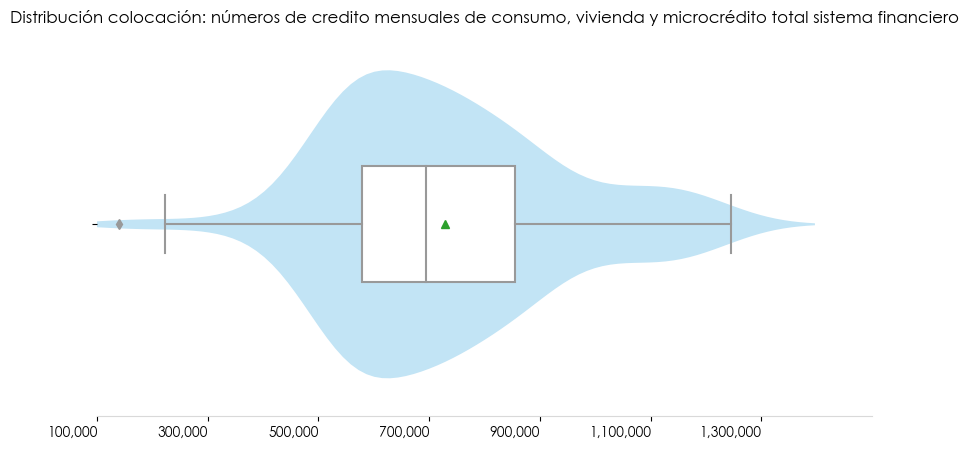

In [23]:
 #Matplotlib :figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE)), Tamaño gráfico
plt.figure(figsize=(10,5)) 
#Configura violín
ax = sns.violinplot(x=df_resumido['NUMERO_CREDITOS'],color="#B9E7FE",linewidth=0) 
#Configura boxplot
boxplot=sns.boxplot(x=df_resumido['NUMERO_CREDITOS'],color="White", showmeans=True, width=0.3, boxprops={'zorder':2}, ax=ax) # seaborn crea el boxplot, showmeans = mostrar media
boxplot.set_xlabel('') # cambia el título del eje x
boxplot.set_xlim(100000, 1500000) # cambia los límites del eje x
boxplot.set_xticks(range(100000, 1500000, 200000)) # cambia los valores del eje x
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x * 1)) # función para el formato de datos del gráfico
boxplot.xaxis.set_major_formatter(formatter) #aplicar función para el formato de datos del gráfico
boxplot.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right') #rotar las etiquetas del eje x
boxplot.set_title('Distribución colocación: números de credito mensuales de consumo, vivienda y microcrédito total sistema financiero')

#Configura opciones de formato del gráfico
boxplot.spines["top"].set_visible(False)
boxplot.spines["right"].set_visible(False)
boxplot.spines["left"].set_visible(False)
plt.rcParams['font.family'] = 'Century Gothic'
plt.gca().spines['bottom'].set_color('#D9D9D9')
#plt.xlabel('FECHA_CORTE', color='#D9D9D9') cambia el color del título del eje x
#plt.tick_params(axis='x', colors='#D9D9D9') cambiar el color de las etiquetas del eje x


plt.show()

El centro de la distribución mensual de nro. de créditos colocados en el sistema financiero, está en 693,508 créditos, con el 50% de los datos agrupados alrededor de este centro entre 140.312 y 855.615 créditos. La dispersión de los datos es baja (de acuerdo a la escala propuesta por Vargas-2007). La distribución contiene un poco de sesgo a la derecha y un poco de empinamiento (concentración respecto a la media).

Adicionalmente existen meses atípicos con nro. de créditos desembolsados menores a 165.015 (Q1 - 1.5RI).

**RECOMENDACIÓN**: estudiar más a fondo los datos atípicos del data set, son situaciones totalmente anormales que deben ser aclaradas.

En el análisis posterior se investigará a fondo estos datos atípicos.

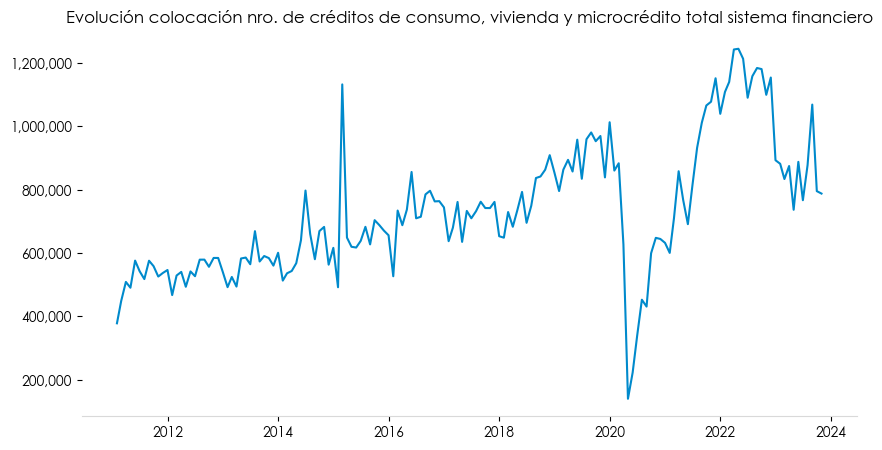

In [24]:
plt.figure(figsize=(10,5)) 
grafico_lineas = sns.lineplot(data=df_resumido, x="FECHA_CORTE", y="NUMERO_CREDITOS", color = "#008ACC")
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x * 1)) # función para el formato de datos del gráfico
grafico_lineas.yaxis.set_major_formatter(formatter) #aplicar función para el formato de datos del gráfico
grafico_lineas.set_title('Evolución colocación nro. de créditos de consumo, vivienda y microcrédito total sistema financiero')
grafico_lineas.set_xlabel("") # cambia el título del eje x
grafico_lineas.set_ylabel("") # cambia el título del eje x

#Configura opciones de formato del gráfico
grafico_lineas.spines["top"].set_visible(False)
grafico_lineas.spines["right"].set_visible(False)
grafico_lineas.spines["left"].set_visible(False)
plt.rcParams['font.family'] = 'Century Gothic'
plt.gca().spines['bottom'].set_color('#D9D9D9')
#plt.xlabel('FECHA_CORTE', color='#D9D9D9') cambia el color del título del eje x
#plt.tick_params(axis='x', colors='#D9D9D9') cambiar el color de las etiquetas del eje x
plt.show()

In [25]:
indice_minimo = df_resumido['NUMERO_CREDITOS'].idxmin()
registro_minimo = df_resumido.loc[indice_minimo]
registro_minimo

FECHA_CORTE           2020-04-30 00:00:00
MONTOS_APROBADOS   2,255,645,328,096.6084
NUMERO_CREDITOS                    140312
year                                 2020
mes                                     4
dia                                    30
Name: 111, dtype: object

**CONCLUSION**: el dato mínimo de nro. de créditos colocados obedece a la declaratoria de cuarentena realizada por el presidente Duque el 22 de marzo de 2020, afectando considerablemente las colocaciones a partir de dicho mes y con mayor impacto histórico en abril de 2020.

**RECOMENDACIÓN**: este dato debe ser teniendo en cuenta para análisis posteriores, ya que representa un cambio de tendencia histórico y acorde a la coyuntura ecónomica y social del país, el cuál puede servir de base para futuras mediciones.

In [26]:
df_filtro = df_resumido[df_resumido["FECHA_CORTE"] < "2016-12-31"]
indice = df_filtro['NUMERO_CREDITOS'].idxmax()
registro_atipico_antes_2016 = df_filtro.loc[indice]
registro_atipico_antes_2016

FECHA_CORTE           2015-02-28 00:00:00
MONTOS_APROBADOS   7,152,949,345,661.2949
NUMERO_CREDITOS                   1132402
year                                 2015
mes                                     2
dia                                    28
Name: 49, dtype: object

Para febrero de 2015, se presenta un comportamiento muy alto en la colocación de la cantidad de créditos: este dato aún sin ser atípico en la totalidad de la historia, si es atípico conforme al período donde se generó.

**RECOMENDACIÓN**: profundizar más sobre el comportamiento de nro. de colocaciones de febrero de 2015: ¿existe alguna entidad o modalidad de crédito en particular que haya causado este efecto?

In [27]:
df_febrero_2015 = df[df["FECHA_CORTE"] == "2015-02-28"]
df_febrero_2015 = df_febrero_2015.sort_values(by = "NUMERO_CREDITOS", ascending =False)
df_febrero_2015.head(5)

,NOMBRE_TIPO_ENTIDAD,NOMBRE_ENTIDAD,FECHA_CORTE,LINEA_CREDITO,MONTOS_APROBADOS,NUMERO_CREDITOS
12625,BC-ESTABLECIMIENTO BANCARIO,Banco Mundo Mujer S.A.,2015-02-28,Compra de Cartera de Microcreditos,"961,238,282,230.0000",470249
12623,BC-ESTABLECIMIENTO BANCARIO,Banco Mundo Mujer S.A.,2015-02-28,Compra Libre Inversion,"72,668,480,761.0000",52140
12626,BC-ESTABLECIMIENTO BANCARIO,Banco Mundo Mujer S.A.,2015-02-28,Microcreditos < o Iguales a 25 SMMLV,"93,200,817,355.0000",40210
12575,BC-ESTABLECIMIENTO BANCARIO,Bancamía S.A.,2015-02-28,Microcreditos < o Iguales a 25 SMMLV,"78,337,916,038.0000",26785
12658,BC-ESTABLECIMIENTO BANCARIO,Bancolombia,2015-02-28,TarjCredito client ingres hasta 2 SMMLV,"32,772,570,000.0000",22607


<function matplotlib.pyplot.show(close=None, block=None)>

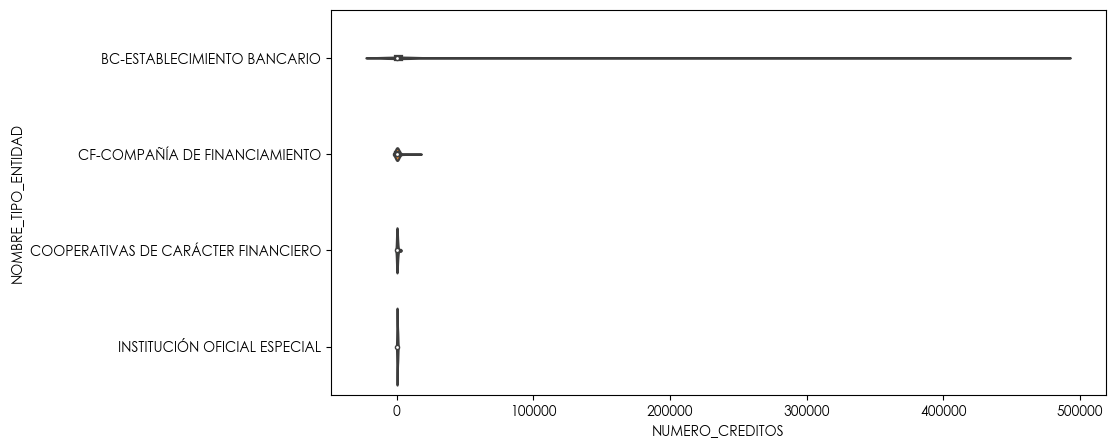

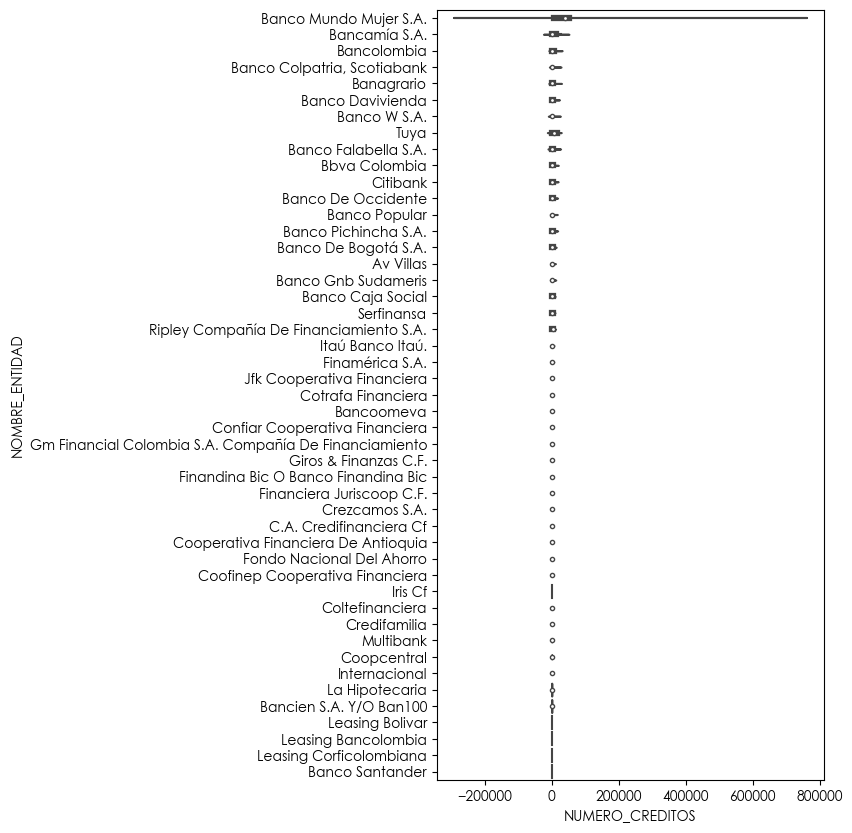

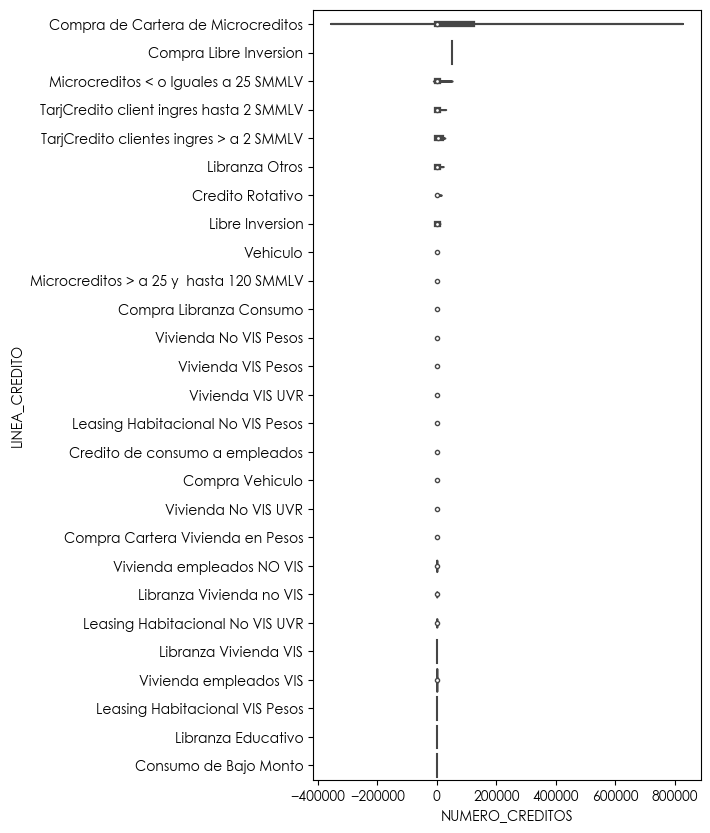

In [28]:
 #Matplotlib :figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE)), Tamaño gráfico
plt.figure(figsize=(10,5)) 
#Configura violín por tipo de entidad
sns.violinplot(y=df_febrero_2015["NOMBRE_TIPO_ENTIDAD"], x=df_febrero_2015['NUMERO_CREDITOS'], data=df_febrero_2015) 
plt.show

plt.figure(figsize=(5,10)) 
sns.violinplot(y=df_febrero_2015["NOMBRE_ENTIDAD"], x=df_febrero_2015['NUMERO_CREDITOS'], data=df_febrero_2015)
plt.show

plt.figure(figsize=(5,10)) 
sns.violinplot(y=df_febrero_2015["LINEA_CREDITO"], x=df_febrero_2015['NUMERO_CREDITOS'], data=df_febrero_2015)
plt.show

**CONCLUSIÓN:** en febrero de 2015 la "FUNDACIÓN MUNDO MUJER" se transforma y empieza operaciones como "BANCO MUNDO MUJER".  Lo anterior implicó una transacción inusual de compra de cartera para lograr migrar la cartera entre entidades.

**RECOMENDACION** eliminar el registro de "Compra de Cartera de Microcreditos" de Banco Mundo Mujer en febrero de 2015, pues en la realidad no fueron nuevas transacciones sino traslados de saldos.

In [29]:
#Se elimina el registro de febrero de 2015 de Compra de Cartera de Microcredito de Bnco Mundo Mujer
registro_a_eliminar = (
    (df["NOMBRE_TIPO_ENTIDAD"] == "BC-ESTABLECIMIENTO BANCARIO") 
    & (df["NOMBRE_ENTIDAD"] == "Banco Mundo Mujer S.A.")
    & (df["FECHA_CORTE"] == "2015-02-28")
    & (df["LINEA_CREDITO"] == "Compra de Cartera de Microcreditos")
)
registro_atipico_antes_2016 = df.loc[registro_a_eliminar]
df = df.drop(df[registro_a_eliminar].index)
df_resumido = df.groupby("FECHA_CORTE").sum().reset_index()

C:\Users\ACER\AppData\Local\Temp\ipykernel_20924\2062292596.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_resumido = df.groupby("FECHA_CORTE").sum().reset_index()


**ACCION CORRECTIVA:** se elimina registro outlier de Banco Mundo Mujer en febrero de 2015 y se vuelve a configurar el dataset

#### Montos aprobados (total sistema)

In [30]:
tabla_descriptivas(df_resumido["MONTOS_APROBADOS"])

,MONTOS_APROBADOS
count,154.0000
mean,"8,379,068,904,790.7568"
std,"3,280,282,085,402.8237"
min,"2,255,645,328,096.6084"
25%,"5,697,072,673,345.7959"
50%,"7,856,101,390,973.8066"
75%,"10,235,434,550,258.8418"
max,"16,697,543,283,546.2734"
coef. variation 0.30 | 0.30-0.70 | 0.70,0.3915
skew < 0 sesgo izquierda | > 0 sesgo derecha,0.5843


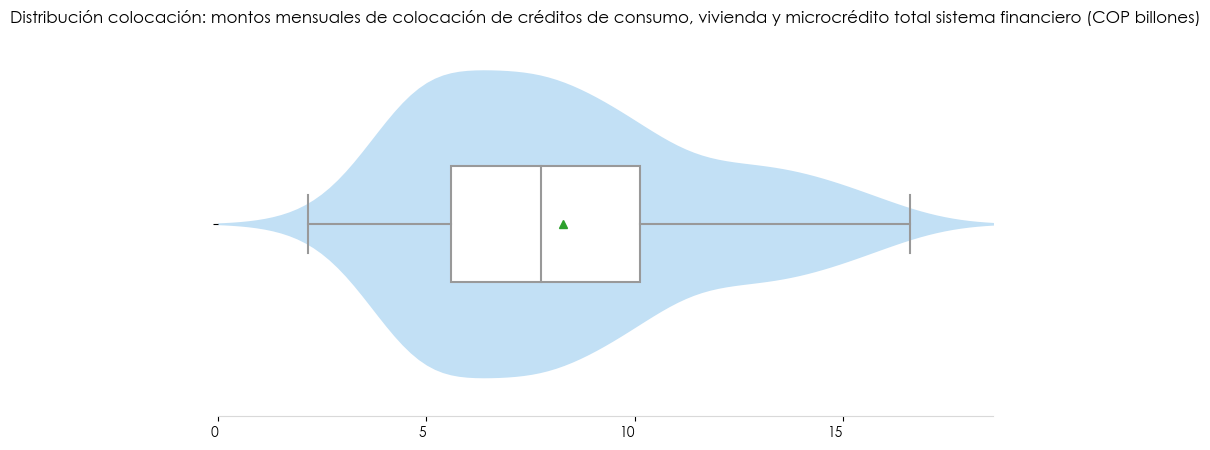

In [31]:
 #Matplotlib :figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE)), Tamaño gráfico
plt.figure(figsize=(10,5)) 
#Configura violín
ax = sns.violinplot(x=df_resumido['MONTOS_APROBADOS'],color="#B9E1FE",linewidth=0) 
#Configura boxplot
boxplot=sns.boxplot(x=df_resumido['MONTOS_APROBADOS'],color="White", showmeans=True, width=0.3, boxprops={'zorder':2}, ax=ax) # seaborn crea el boxplot, showmeans = mostrar media
boxplot.set_xlabel('') # cambia el título del eje x
boxplot.set_xlim(100000000000, 18697543283546) # cambia los límites del eje x
boxplot.set_xticks(range(100000000000, 18697543283546, 5000000000000)) # cambia los valores del eje x
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x * 1e-12)) # función para el formato de datos del gráfico
boxplot.xaxis.set_major_formatter(formatter) #aplicar función para el formato de datos del gráfico
boxplot.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right') #rotar las etiquetas del eje x
boxplot.set_title('Distribución colocación: montos mensuales de colocación de créditos de consumo, vivienda y microcrédito total sistema financiero (COP billones)')
boxplot.spines["top"].set_visible(False)
boxplot.spines["right"].set_visible(False)
boxplot.spines["left"].set_visible(False)

#Configura opciones de formato del gráfico
grafico_lineas.spines["top"].set_visible(False)
grafico_lineas.spines["right"].set_visible(False)
grafico_lineas.spines["left"].set_visible(False)
plt.rcParams['font.family'] = 'Century Gothic'
plt.gca().spines['bottom'].set_color('#D9D9D9')
#plt.xlabel('FECHA_CORTE', color='#D9D9D9') cambia el color del título del eje x
#plt.tick_params(axis='x', colors='#D9D9D9') cambiar el color de las etiquetas del eje x
plt.show()


plt.show()

El centro de la distribución mensual del monto de créditos colocados en el sistema financiero (consumo, vivienda y microcrédito), está en 7.85 billones de pesos, con el 50% de los datos agrupados alrededor de este centro entre 5.69 billones de pesos y 10.23 billones. La dispersión de los datos es baja (de acuerdo a la escala propuesta por Vargas-2007). La distribución contiene sesgo a la derecha y es achatada (poca concentración respecto a la media).

No existen meses con datos atípicos.

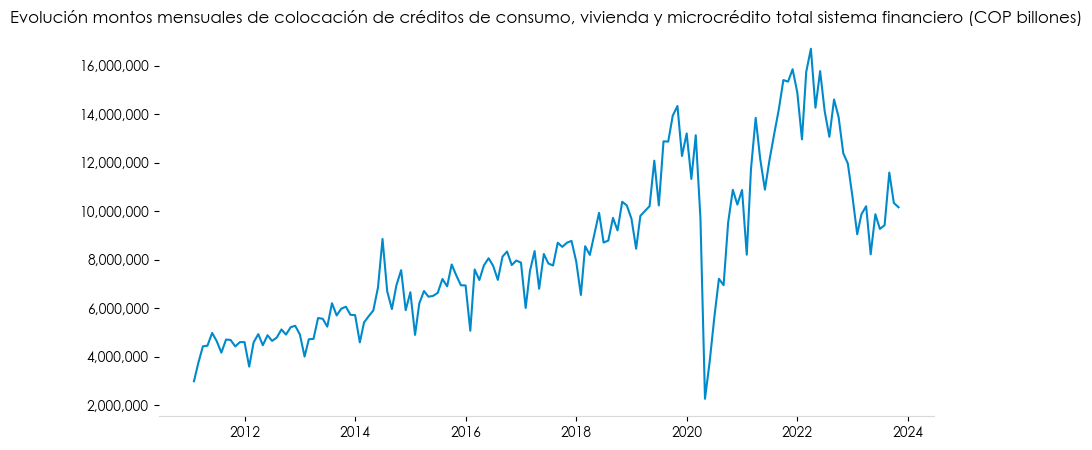

In [32]:
plt.figure(figsize=(10,5)) 
grafico_lineas = sns.lineplot(data=df_resumido, x="FECHA_CORTE", y="MONTOS_APROBADOS", color = "#008ACC")
grafico_lineas.set_xlabel('')
grafico_lineas.set_ylabel('')
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x * 1e-6)) # función para el formato de datos del gráfico
grafico_lineas.yaxis.set_major_formatter(formatter) #aplicar función para el formato de datos del gráfico
boxplot.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right') #rotar las etiquetas del eje x
grafico_lineas.set_title('Evolución montos mensuales de colocación de créditos de consumo, vivienda y microcrédito total sistema financiero (COP billones)')

#Configura opciones de formato del gráfico
grafico_lineas.spines["top"].set_visible(False)
grafico_lineas.spines["right"].set_visible(False)
grafico_lineas.spines["left"].set_visible(False)
plt.rcParams['font.family'] = 'Century Gothic'
plt.gca().spines['bottom'].set_color('#D9D9D9')
#plt.xlabel('FECHA_CORTE', color='#D9D9D9') cambia el color del título del eje x
#plt.tick_params(axis='x', colors='#D9D9D9') cambiar el color de las etiquetas del eje x
plt.show()



**CONCLUSIÓN**: la evolución de los montos desembolsados y nro. de créditos de consumo, vivienda y microcrédito tuvieron un comportamiento creciente desde el año 2012 hasta el año de 2020, donde de manera atípica sucedieron eventos pandémicos afectando negativamente su comportamiendo.  A partir del 2020 la colocación se recupera teniendo altibajos hasta la actualidad.

Los datos atípicos de montos desembolsados para el año 2020, deben ser tenidos en cuenta en análisis posteriores, dado que este comportamiento sirve de base para proyectar recuperaciones en la actividad de las colocaciones en períodos posteriores a crisis económicas. 

Adicionalmente, en febrero de 2015 se presenta la incorporación de una nueva entidad financiera de microcréditos, afectando el nro. de desembolsos colocados: la recomendación realizada fue eliminar el registro respectivo.

## Merge tasa de intervención

Una vez teniendo nuestra serie de tiempo de desembolsos analizada, procedemos a hacer el merge con la tasa de intervención mensual

In [33]:
df_intervencion = pd.read_excel("04_tasa_intervencion.xlsx")
df_intervencion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FECHA_CORTE        154 non-null    datetime64[ns]
 1   TASA_INTERVENCION  154 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 KB


Se observa que la información no presenta datos vacíos, pues obedede a datos de obligatorio reporte por parte del Banco Central. Adicionalmente, se encuentran 154 fechas, equivalentes a los 154 cortes de nuestro análisis.  El tipo de datos de la tasa de intervención es un float, lo cual es correcto.

In [34]:
df_resumido = pd.merge(df_resumido, df_intervencion, on="FECHA_CORTE", how="inner")
df_resumido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 153
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FECHA_CORTE        154 non-null    datetime64[ns]
 1   MONTOS_APROBADOS   154 non-null    float64       
 2   NUMERO_CREDITOS    154 non-null    int64         
 3   TASA_INTERVENCION  154 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 6.0 KB


In [35]:
df_resumido.tail(2)

,FECHA_CORTE,MONTOS_APROBADOS,NUMERO_CREDITOS,TASA_INTERVENCION
152,2023-09-30,"10,337,218,868,057.6445",795624,0.1325
153,2023-10-31,"10,157,549,003,446.2324",787908,0.1325


#### Análisis descriptivo tasa de intervención

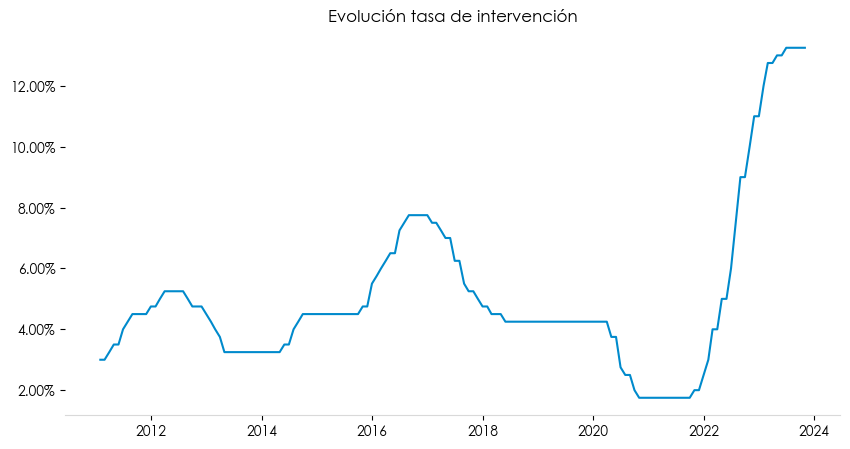

In [36]:
plt.figure(figsize=(10,5)) 
grafico_lineas = sns.lineplot(data=df_resumido, x="FECHA_CORTE", y="TASA_INTERVENCION", color = "#008ACC")
grafico_lineas.set_xlabel('')
grafico_lineas.set_ylabel('')
formatter = ticker.FuncFormatter(lambda x, pos: '{:.2%}'.format(x * 1)) # función para el formato de datos del gráfico
grafico_lineas.yaxis.set_major_formatter(formatter) #aplicar función para el formato de datos del gráfico
boxplot.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right') #rotar las etiquetas del eje x
grafico_lineas.set_title('Evolución tasa de intervención')

#Configura opciones de formato del gráfico
grafico_lineas.spines["top"].set_visible(False)
grafico_lineas.spines["right"].set_visible(False)
grafico_lineas.spines["left"].set_visible(False)
plt.rcParams['font.family'] = 'Century Gothic'
plt.gca().spines['bottom'].set_color('#D9D9D9')
#plt.xlabel('FECHA_CORTE', color='#D9D9D9') cambia el color del título del eje x
#plt.tick_params(axis='x', colors='#D9D9D9') cambiar el color de las etiquetas del eje x
plt.show()

La tasa de intervención, es el instrumento con el que cuenta el Banco Central para frenar la inflación, la demanda y el crecimiento económico en el corto plazo, para que a mediano plazo los precios retrocedan y la inflación disminuya. En la actualidad este indicador se encuentra en uno de los momentos más altos de la historia económica colombiana ya que el Banco Central busca frenar la inflación desbordada generada por efectos postpandemia.

## Analisis multivariado

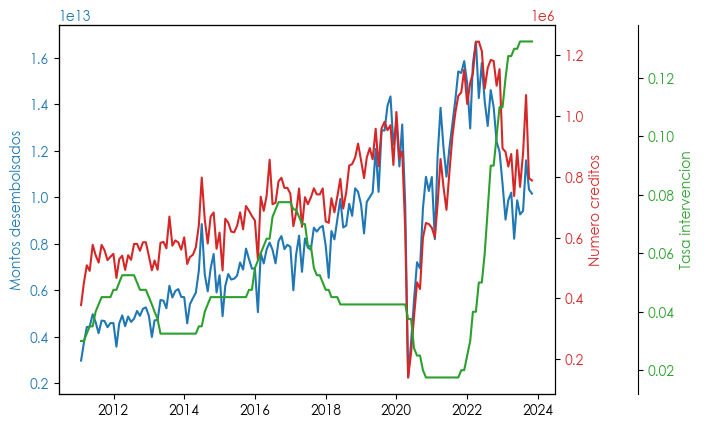

In [37]:
fechas = df_resumido["FECHA_CORTE"]
montos_aprobados = df_resumido["MONTOS_APROBADOS"]
numero_creditos = df_resumido["NUMERO_CREDITOS"]
tasa_intervencion = df_resumido["TASA_INTERVENCION"]

# Datos de ejemplo
x = [1, 2, 3, 4, 5]
y1 = [10, 15, 20, 25, 30]
y2 = [5, 8, 12, 18, 22]

# Crear una figura y ejes
fig, ax1 = plt.subplots()

# Trazar la primera serie de datos (y1) en el primer eje (izquierdo)
color = 'tab:blue'
ax1.set_xlabel('')
ax1.set_ylabel('Montos desembolsados', color=color)
ax1.plot(fechas, montos_aprobados, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Crear el segundo eje (derecho)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Numero creditos', color=color)
ax2.plot(fechas, numero_creditos, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Tercer eje y
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Tasa intervencion', color='tab:green')
ax3.plot(fechas, tasa_intervencion, color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Mostrar el gráfico
plt.show()

En el gráfico se observa correlación entre los montos y créditos desembolsados.  Sin embargo, la tasa de intervención muestra un patrón de correlación negativo en algunas ocasiones, si se analiza la tendencia en períodos superiores a un mes.

### Correlación entre los montos desembolsados , créditos desembolsados y tasa de intervención

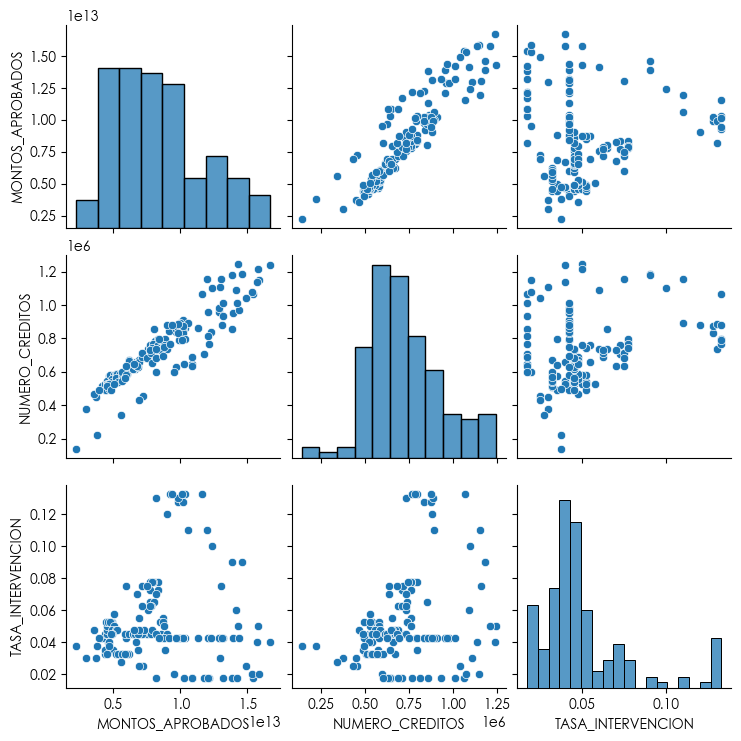

In [38]:
sns.pairplot(df_resumido)

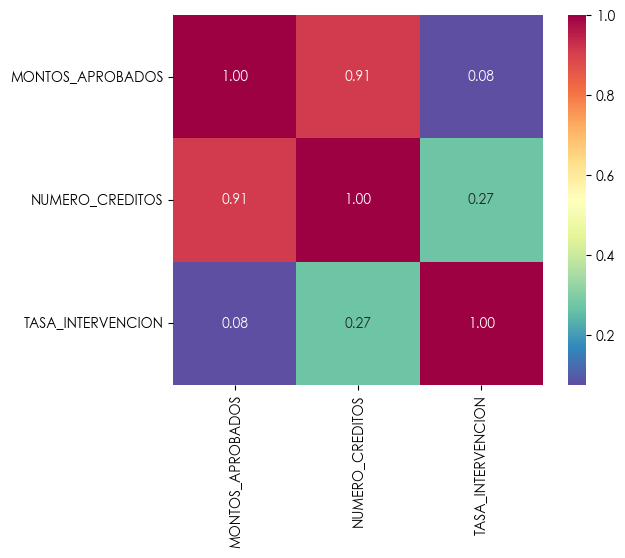

In [39]:
# Correlacion entre variables
df_correlacion = df_resumido[["MONTOS_APROBADOS", "NUMERO_CREDITOS", "TASA_INTERVENCION"]]
corrmat = df_correlacion.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=df_correlacion.columns, 
                 xticklabels=df_correlacion.columns, 
                 cmap="Spectral_r")
plt.show()

Los montos desembolsados y la cantidad de créditos presentan una correlación cercana positiva cercana a 1 (colinealidad), sin embargo la tasa de intervención mensual no presenta correlación con los indiciadores anteriores.

**RECOMENDACION:** construir el modelo predictivo a partir de de los montos desembolsados ya que es un indicador que no está sesgado por las particularidades de los productos (ejemplo: la cantidad de tarjetas de crédito Vs. los créditos de vivienda difieren en un contexto de negocio)

## Modelo predictivo

In [40]:
df_resumido["year"] = [x.year for x in df_resumido.FECHA_CORTE]
df_resumido["mes"] = [x.month for x in df_resumido.FECHA_CORTE]
df_resumido["dia"] = [x.day for x in df_resumido.FECHA_CORTE]
df_resumido.head(1)

,FECHA_CORTE,MONTOS_APROBADOS,NUMERO_CREDITOS,TASA_INTERVENCION,year,mes,dia
0,2011-01-31,"2,981,208,267,185.6870",378499,0.0300,2011,1,31


Se divide la columna "FECHA_CORTE" y se configuran columnas numéricas "year", "mes" y "día" para el entendimiento del modelo

In [41]:
X = df_resumido.loc[:,["year", "mes", "dia", "TASA_INTERVENCION"]]
y = df_resumido.loc[:,["MONTOS_APROBADOS"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Se realiza el split de los datos

### Normalización del modelo, elección de modelo predictivo y pipeline

In [42]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))  
])

Se aplica un StandardScaler debido a la magnitud de los valores a analizar (cifras en billones de pesos)

Se aplica un modelo predicitivo RandomForestRegressor


### Entrenamiento del modelo y pipeline

In [43]:
# Entrenar el modelo utilizando el pipeline
pipeline.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
Predicciones = pipeline.predict(X_test)

C:\Users\ACER\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


### Validaciones del modelo

#### Error cuadrático medio

In [44]:
mse = mean_squared_error(y_test, Predicciones)
print("Resultado: {:,.1f}".format(mse))

Resultado: 1,568,930,766,885,828,025,122,816.0


Al validar cifras en términos de billones de pesos, el error cuadrático medio genera valores muy altos.

**RECOMENDACIÓN** validar otra métricas de validación del modelo

#### Error absoluto medio

In [45]:
mae = mean_absolute_error(y_test, Predicciones)
print("Resultado: {:,.1f}".format(mae))

Resultado: 805,861,253,280.1


El error absoluto medio (MAE) mide la magnitud promedio de los errores en un conjunto de predicciones, proporcionando un valor numérico que representa qué tan lejos están los pronósticos de los valores reales. 

En promedio el resultado de predicción se aleja del real en 0.82 billones de pesos, representando aproximadamente el 10% del promedio de montos histórico de colocaciones mensuales de 8 billones de pesos.

#### R-cuadrado

In [46]:
r2 = r2_score(y_test, Predicciones)
r2

0.8644109946732325

Dado que el valor de R-cuadrado es de 0.90, se considera que el modelo se ajusta bien a los datos

### Aplicación del modelo

#### Análisis datos de prueba

In [47]:
df_prueba = df_resumido.loc[X_test.index,["FECHA_CORTE","MONTOS_APROBADOS"]]
df_prueba["Predicciones"] = Predicciones
df_prueba = df_prueba.sort_values(by = "FECHA_CORTE")
df_prueba = df_prueba.reset_index(drop=True)
df_prueba

,FECHA_CORTE,MONTOS_APROBADOS,Predicciones
0,2011-01-31,"2,981,208,267,185.6870","4,056,886,050,465.5327"
1,2011-09-30,"4,681,863,893,408.0186","4,568,972,025,552.6992"
2,2011-12-31,"4,593,491,002,043.8887","4,736,686,342,363.8711"
3,2012-03-31,"4,923,892,020,629.3779","4,689,866,079,364.0635"
4,2012-04-30,"4,463,406,196,148.4512","4,690,821,382,148.8408"
5,2014-03-31,"5,665,458,169,825.8691","5,432,932,945,953.1582"
6,2014-12-31,"6,651,577,616,237.0977","6,523,656,366,082.7061"
7,2015-01-31,"4,893,070,243,885.3965","6,294,620,744,754.1963"
8,2015-02-28,"6,191,711,063,431.2949","6,398,762,707,081.7676"
9,2015-03-31,"6,702,179,329,213.9482","6,526,682,303,235.4824"


Se construye dataframe para analizar los datos prueba: real vs. pronóstico

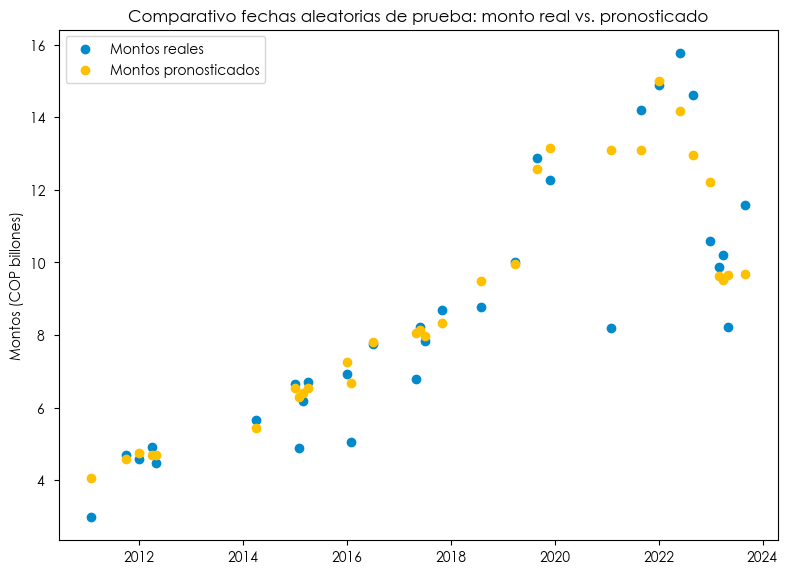

In [48]:
x1 = df_prueba["FECHA_CORTE"]
y1= df_prueba["MONTOS_APROBADOS"]
x2 =  df_prueba["FECHA_CORTE"]
y2 = df_prueba["Predicciones"]

# Crear el gráfico de dispersión con colores diferentes
plt.figure(figsize=(8, 6))
plt.scatter(x1, y1, color='#008ACC', label='Montos reales')  # Puntos del grupo 1 serán azules
plt.scatter(x2, y2, color='#FFC000', label='Montos pronosticados')   # Puntos del grupo 2 serán rojos

# Añadir etiquetas y título
plt.xlabel('')
plt.ylabel('Montos (COP billones)')
plt.title('Comparativo fechas aleatorias de prueba: monto real vs. pronosticado')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(False)
plt.tight_layout()


# Formatear el eje y para mostrar en billones
def formato(x, pos):
    return '{:.0f} '.format(x * 1e-12)
formatter = FuncFormatter(formato)
plt.gca().yaxis.set_major_formatter(formatter)


plt.show()

Al analizar los datos de prueba se observa coherencia del pronóstico frente a la tendencia de los datos reales.  Sin embargo, en algunas fechas con movimiento muy fuertes como abril de 2020 (inicio pandemia), el pronóstico se aleja en gran medida de su dato real. 

#### Análisis data set completo

In [49]:
prediccion_completa = pipeline.predict(df_resumido.loc[:,["year", "mes", "dia", "TASA_INTERVENCION"]])

In [50]:
df_visual_prueba = df_resumido.copy()
df_visual_prueba["Predicciones"] = prediccion_completa
df_visual_prueba.tail(3)

,FECHA_CORTE,MONTOS_APROBADOS,NUMERO_CREDITOS,TASA_INTERVENCION,year,mes,dia,Predicciones
151,2023-08-31,"11,589,589,004,000.7344",1068699,0.1325,2023,8,31,"9,669,496,912,201.5742"
152,2023-09-30,"10,337,218,868,057.6445",795624,0.1325,2023,9,30,"10,229,676,815,597.7773"
153,2023-10-31,"10,157,549,003,446.2324",787908,0.1325,2023,10,31,"10,189,246,439,358.5195"


Se crea nuevo dataframe con los datos reales completos junto a su prediccion

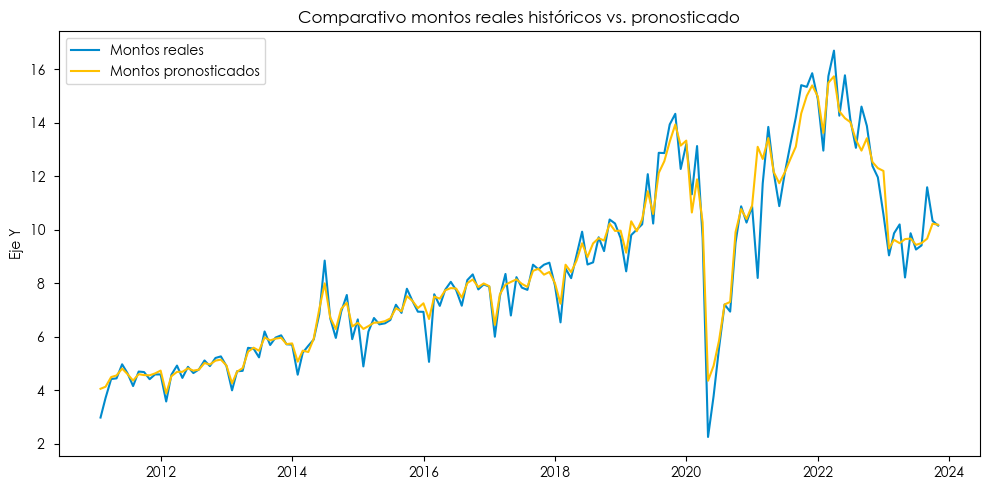

In [51]:
x = df_visual_prueba["FECHA_CORTE"]
y1 = df_visual_prueba["MONTOS_APROBADOS"]
y2 = df_visual_prueba["Predicciones"]

# Crear el gráfico de líneas con colores diferentes para cada serie
plt.figure(figsize=(10, 5))
plt.plot(x, y1, color='#008ACC', label='Montos reales')  # Serie 1 en azul
plt.plot(x, y2, color='#FFC000', label='Montos pronosticados')   # Serie 2 en rojo

# Añadir etiquetas y título
plt.xlabel("")
plt.ylabel('Eje Y')
plt.title('Comparativo montos reales históricos vs. pronosticado')
plt.legend()

# Formatear el eje y para mostrar en billones
def formato(x, pos):
    return '{:.0f} '.format(x * 1e-12)
formatter = FuncFormatter(formato)
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.grid(False)
plt.tight_layout()
plt.show()

Al analizar los datos de prueba, se observa coherencia del pronóstico frente a la tendencia de los datos reales.  Sin embargo, en algunas fechas con fuertes movimientos el pronóstico no es el indicado.

### Escenarios de presupuesto de montos desembolsados

**RECOMENDACIÓN**

Dado que los movimientos en tasa de intervención son inciertos por parte del Banco de la República se recomienda crear 3 posibles escenarios para 2024:

    1) Intervención neutro: el Banrep deja constantes las tasas de interés
    2) Intervención bajista lenta: el Banrep disminuye las tasas de interés a un ritmo lento : 0.25 Pbs. por mes
    3) Intervención bajista rapida: el Banrep disminuye las tasas de interés a un ritmo rápido : 0.50 Pbs. por mes

In [52]:
df_intervencion_neutro = pd.read_excel("20240305_03_Escenario_neutro.xlsx")
df_resumido_escenario_neutro = df_resumido.append(df_intervencion_neutro, ignore_index=True)
prediccion_completa_neutro = pipeline.predict(df_resumido_escenario_neutro.loc[:,["year", "mes", "dia", "TASA_INTERVENCION"]])
df_visual_prueba_neutro = df_resumido_escenario_neutro.copy()
df_visual_prueba_neutro["Predicciones_neutro"] = prediccion_completa_neutro

df_intervencion_bajista_lento = pd.read_excel("20240305_04_Escenario_bajista_lento.xlsx")
df_resumido_escenario_bajista_lento = df_resumido.append(df_intervencion_bajista_lento, ignore_index=True)
prediccion_completa_bajista_lento = pipeline.predict(df_resumido_escenario_bajista_lento.loc[:,["year", "mes", "dia", "TASA_INTERVENCION"]])
df_visual_prueba_bajista_lento = df_resumido_escenario_bajista_lento.copy()
df_visual_prueba_bajista_lento["Predicciones_bajista_lento"] = prediccion_completa_bajista_lento

df_intervencion_bajista_rapido = pd.read_excel("20240305_04_Escenario_bajista_rapido.xlsx")
df_resumido_escenario_bajista_rapido = df_resumido.append(df_intervencion_bajista_rapido, ignore_index=True)
prediccion_completa_bajista_rapido = pipeline.predict(df_resumido_escenario_bajista_rapido.loc[:,["year", "mes", "dia", "TASA_INTERVENCION"]])
df_visual_prueba_bajista_rapido = df_resumido_escenario_bajista_rapido.copy()
df_visual_prueba_bajista_rapido["Predicciones_bajista_rapido"] = prediccion_completa_bajista_rapido

df_escenarios = (
    pd.merge(pd.merge(df_visual_prueba_neutro, df_visual_prueba_bajista_lento[["Predicciones_bajista_lento"]], left_index=True, right_index=True), df_visual_prueba_bajista_rapido[["Predicciones_bajista_rapido"]], left_index=True, right_index=True)
)

df_escenarios.tail(14)

C:\Users\ACER\AppData\Local\Temp\ipykernel_20924\1119541761.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resumido_escenario_neutro = df_resumido.append(df_intervencion_neutro, ignore_index=True)
C:\Users\ACER\AppData\Local\Temp\ipykernel_20924\1119541761.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resumido_escenario_bajista_lento = df_resumido.append(df_intervencion_bajista_lento, ignore_index=True)
C:\Users\ACER\AppData\Local\Temp\ipykernel_20924\1119541761.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resumido_escenario_bajista_rapido = df_resumido.append(df_intervencion_bajista_rapido, ignore_index=True)


,FECHA_CORTE,MONTOS_APROBADOS,NUMERO_CREDITOS,TASA_INTERVENCION,year,mes,dia,Predicciones_neutro,Predicciones_bajista_lento,Predicciones_bajista_rapido
154,2023-11-30,NaN,NaN,0.1325,2023,11,30,"10,365,084,133,769.7109","10,365,084,133,769.7109","10,365,084,133,769.7109"
155,2023-12-31,NaN,NaN,0.1300,2023,12,31,"10,344,977,577,673.1953","10,344,977,577,673.1953","10,344,977,577,673.1953"
156,2024-01-31,NaN,NaN,0.1300,2024,1,31,"9,490,098,763,278.4570","9,490,098,763,278.4570","9,490,098,763,278.4570"
157,2024-02-29,NaN,NaN,0.1275,2024,2,29,"9,600,820,555,588.0586","9,600,820,555,588.0586","9,600,820,555,588.0586"
158,2024-03-31,NaN,NaN,0.1275,2024,3,31,"9,500,569,948,863.7734","9,248,545,036,234.1719","9,248,545,036,234.1719"
159,2024-04-30,NaN,NaN,0.1275,2024,4,30,"9,652,485,152,998.2910","9,425,307,164,520.4375","9,654,821,918,791.4023"
160,2024-05-31,NaN,NaN,0.1275,2024,5,31,"9,672,653,652,788.0020","9,484,087,712,225.6328","10,228,515,003,361.6758"
161,2024-06-30,NaN,NaN,0.1275,2024,6,30,"9,589,793,540,299.7109","9,628,594,760,664.5371","10,603,537,556,234.0078"
162,2024-07-31,NaN,NaN,0.1275,2024,7,31,"9,625,461,319,198.1855","10,211,444,790,550.6270","10,890,666,997,730.2285"
163,2024-08-31,NaN,NaN,0.1275,2024,8,31,"9,779,586,008,577.8008","10,317,620,470,780.0488","11,171,221,904,053.6562"


Se crea nuevo dataframe consolidado los 3 escenarios de tasa de intervención

#### Análisis y  visualización de  escenarios de presupuesto

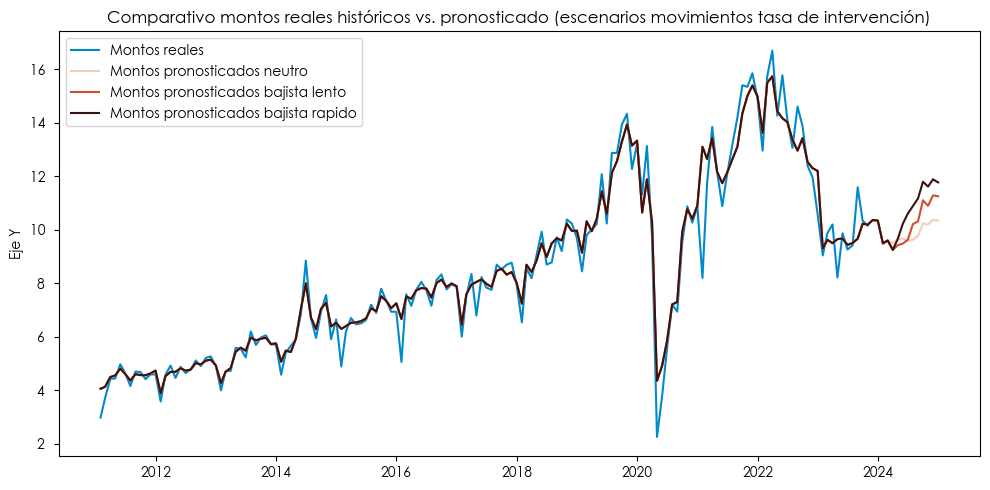

In [53]:
x = df_escenarios["FECHA_CORTE"]
y1 = df_escenarios["MONTOS_APROBADOS"]
y2 = df_escenarios["Predicciones_neutro"]
y3 = df_escenarios["Predicciones_bajista_lento"]
y4 = df_escenarios["Predicciones_bajista_rapido"]

# Crear el gráfico de líneas con colores diferentes para cada serie
plt.figure(figsize=(10, 5))
plt.plot(x, y1, color='#008ACC', label='Montos reales')  # Serie 1 en azul
plt.plot(x, y2, color='#F1CEB7', label='Montos pronosticados neutro')   # Serie 2 en rojo
plt.plot(x, y3, color='#D0512F', label='Montos pronosticados bajista lento')   # Serie 2 en rojo
plt.plot(x, y4, color='#3A1310', label='Montos pronosticados bajista rapido')   # Serie 2 en rojo

# Añadir etiquetas y título
plt.xlabel("")
plt.ylabel('Eje Y')
plt.title('Comparativo montos reales históricos vs. pronosticado (escenarios movimientos tasa de intervención)')
plt.legend()

# Formatear el eje y para mostrar en billones
def formato(x, pos):
    return '{:.0f} '.format(x * 1e-12)
formatter = FuncFormatter(formato)
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.grid(False)
plt.tight_layout()
plt.show()

Se observa congruencia con la lógica económica planteada, dado que los montos desembolsados, deberían comportarse en el siguiente orden ascendente por escenario:

    1) Escenario neutro: presenta la menor magnitud de montos desembolsados.
    2) Escenario bajista_lento: presenta la 2da menor magnitud de montos desembolsados.
    3) Escenario bajista_rapido: presenta la mayor cantidad de montos desembolsados.

## Recomendaciones y conclusiones finales

“¿Cuál es el comportamiento de la tasa de intervención y de los montos y nro. de créditos de consumo, vivienda y microcrédito, desembolsados en el sistema financiero desde enero de 2011 hasta octubre de 2023?”:

La cartera de créditos en referencia ha presentado un comportamiento ascendente con 2 puntos atípicos en la historia: el primero es le llegada de un nuevo banco el cual debe ser descartado del análisis, el segundo es la pandemia de 2020 el cual debe ser tenido en cuanta porque ayuda a comprender la acción de la política monetaria en la economía

“¿Cuáles serán los montos desembolsados de créditos de consumo, vivienda y microcrédito en el sistema financiero para el 2024, conforme a la tasa de intervención del Banco de la República?”

Dado que los movimientos en tasa de intervención son inciertos por parte del Banco de la República se recomienda crearon 3 posibles escenarios para el presupuesto 2024.

El Comité de Gerencia conforme a su experiencia deberá elegir cuál es el escenario que más se adapta a la realidad económica colombiana.

Adicionalmente, dado los resultados de predicción del modelo se recomienda explorar otros métodos de predicción como series de tiempo, pues los resultados del error cuadrático medio y error absoluto medio fueron variables y no óptimos
